# Imports

In [1]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# custom functions
from evaluation_functions import time_based_evaluation, evaluate_model_with_train
from pipeline_transformers import LogTransformer, FeatureCreation, FeatureRemoval

C:\Users\nbeha\AppData\Local\Temp\ipykernel_16584\1198315301.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data ingestion

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
valid = pd.read_csv('valid.csv')
all_data = pd.concat([train, test, valid])

# treatments applied to the training data (check EDA notebook for details)
train = train[train['general_a_vencer_weighted_periodo_div_pct_risco'] >= 0]

keys = ['fake_cnpj', 'date_reference']
target = 'TARGET_default_within_11m'

features = [
    'chk_esp_cred_rot_a_vencer_pct_risco',
    'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
    'cnt_declined_reasons',
    'days_since_oldest_board_member',
    'general_a_vencer_pct_risco',
    'general_a_vencer_weighted_periodo_div_pct_risco',
    'general_limite_de_cred_sum_pct_risco',
    'general_limite_trend_6mo',
    'general_lost_pct_cart_cred',
    'general_lost_pct_risco',
    'general_vencido_max_prev_6mo',
    'general_vencido_pct_carteira_cred__max_prev_6mo',
    'general_vencido_pct_risco_max_prev_6mo',
    'general_vencido_sum_sum_pct_risco',
    'v204r_is_popular_domain',
    'v254r_cnt_board_memebers',
    'years_since_first_relationship',
    'general_limite_de_cred_sum',
    'general_lost_sum',
    'general_vencido_sum'
    ]

# features that may induce bias/information from other models


# Model pipeline

## Baseline model

In [3]:
baseline_model = Pipeline([
    ('model', LGBMClassifier(random_state=5, verbose=-1))
])

all_columns = [c for c in train.columns if c not in keys + [target]]

baseline_model.fit(train[all_columns], train[target])
preds = baseline_model.predict_proba(test[all_columns])[:, 1]
train_preds = baseline_model.predict_proba(train[all_columns])[:, 1]

In [4]:
# Train
print('AUC:', roc_auc_score(train[target], train_preds))
print('Precision:', precision_score(train[target], train_preds > 0.5))
print('Recall:', recall_score(train[target], train_preds > 0.5))
print('Confusion Matrix:')
print(confusion_matrix(train[target], train_preds > 0.5))
print(confusion_matrix(train[target], train_preds > 0.5, normalize='true'))

AUC: 0.9990734509921454
Precision: 0.9986072423398329
Recall: 0.9041614123581336
Confusion Matrix:
[[4459    1]
 [  76  717]]
[[9.99775785e-01 2.24215247e-04]
 [9.58385876e-02 9.04161412e-01]]


In [5]:
# Test
print('AUC:', roc_auc_score(test[target], preds))
print('Precision:', precision_score(test[target], preds > 0.5))
print('Recall:', recall_score(test[target], preds > 0.5))
print('Confusion Matrix:')
print(confusion_matrix(test[target], preds > 0.5))
print(confusion_matrix(test[target], preds > 0.5, normalize='true'))

AUC: 0.8339451303918415
Precision: 0.547683923705722
Recall: 0.21883505715841045
Confusion Matrix:
[[15651   332]
 [ 1435   402]]
[[0.97922793 0.02077207]
 [0.78116494 0.21883506]]


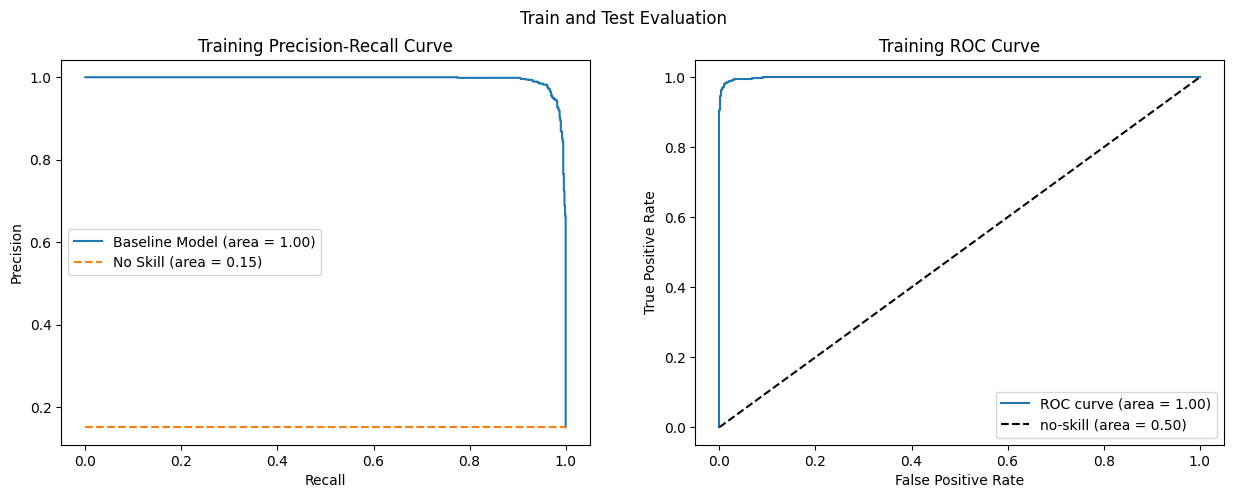

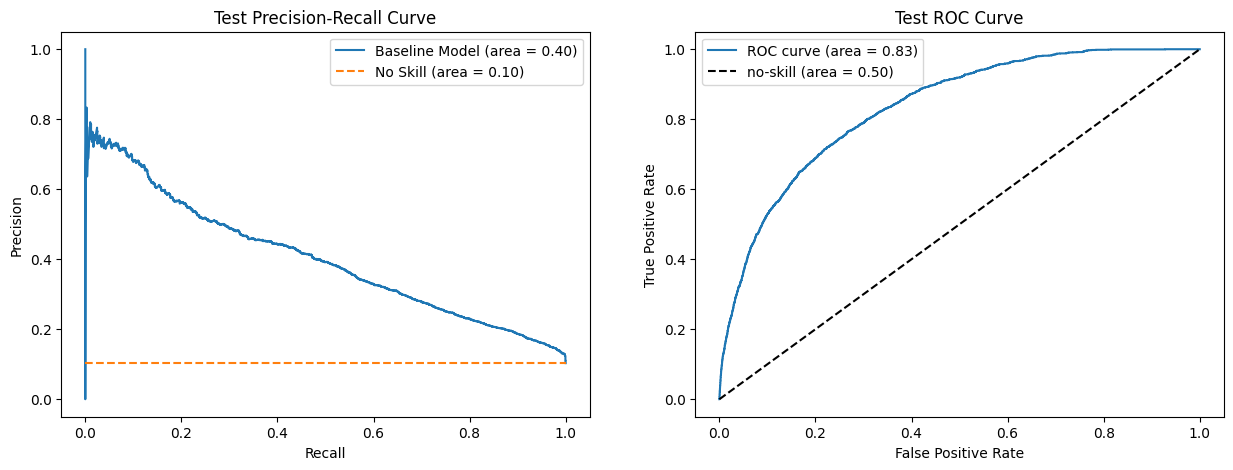

In [6]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

## Model with reduced feature set

In [7]:
log_transform_features = [
    'chk_esp_cred_rot_a_vencer_pct_risco',
    'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
    'general_limite_de_cred_sum',
    'general_limite_trend_6mo',
    'general_lost_pct_cart_cred',
    'general_lost_pct_risco',
    'general_lost_sum',
    'general_vencido_max_prev_6mo',
    'general_vencido_pct_carteira_cred__max_prev_6mo',
    'general_vencido_pct_risco_max_prev_6mo',
    'general_vencido_sum',
    'general_vencido_sum_sum_pct_risco']

model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('lgbm', LGBMClassifier(max_depth=5, random_state=123, verbose=-1))
])

model.fit(train[features], train[target])
preds = model.predict_proba(test[features])[:, 1]
train_preds = model.predict_proba(train[features])[:, 1]

c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
c:\Users\nbeha\DS\credit-model\pipeline_transformers.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["general_lost_sum__over__general_limite_de_cred_sum"] = (
c:\Users\nbeh

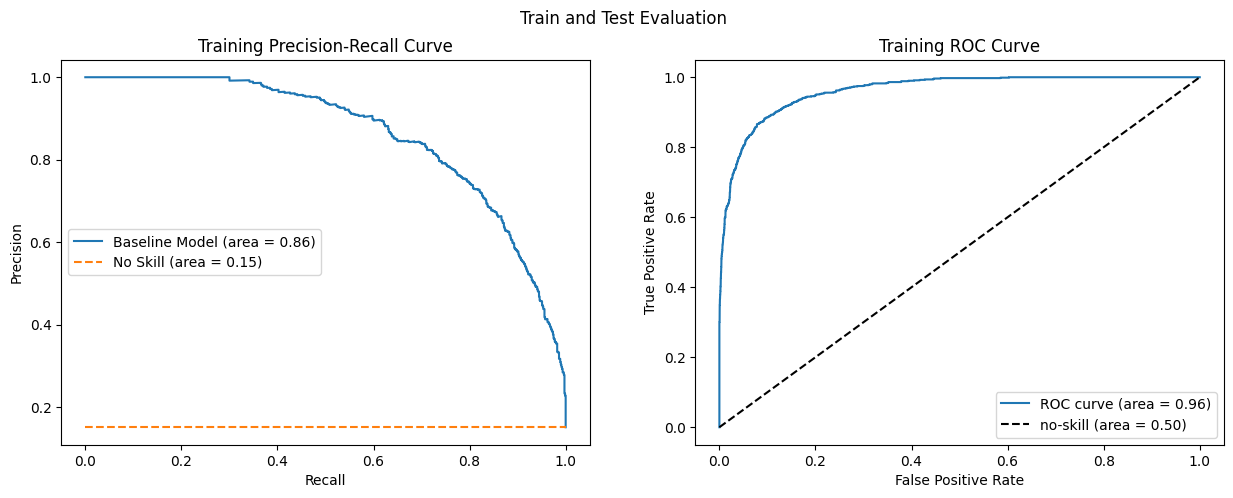

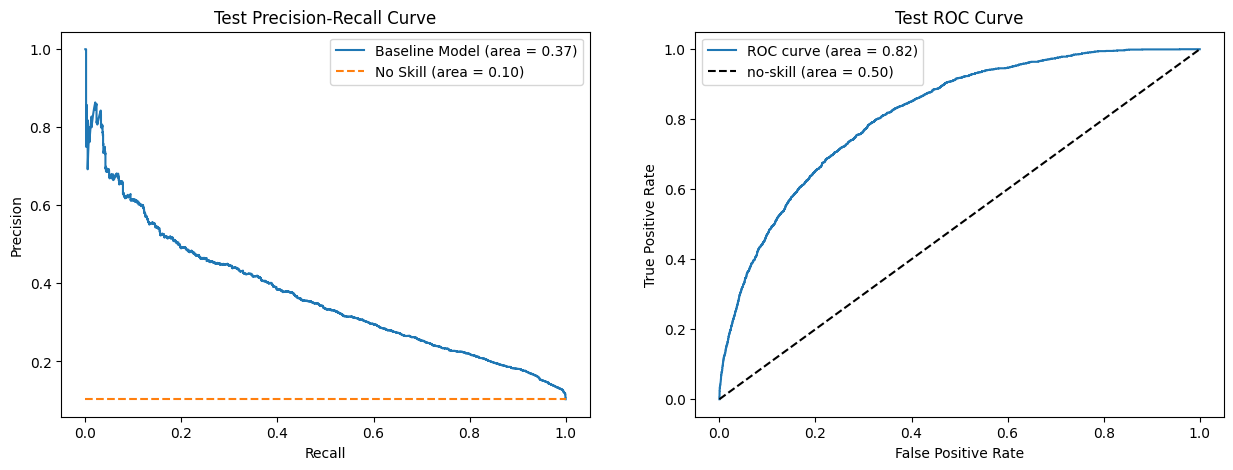

In [8]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

In [9]:
baseline_importances = pd.DataFrame(baseline_model[0].feature_importances_, index=all_columns, columns=['importance']).sort_values('importance', ascending=False)
new_importances = pd.DataFrame(model[3].feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)

In [10]:
baseline_importances.join(new_importances, how='outer', lsuffix='_baseline', rsuffix='_new').fillna(0).sort_values('importance_baseline', ascending=False)

,importance_baseline,importance_new
years_since_first_relationship,179,232.0
general_a_vencer_weighted_periodo_div_pct_risco,171,212.0
v001r_social_capital,153,0.0
general_limite_trend_6mo,147,156.0
general_a_vencer_under30d,144,0.0
days_since_oldest_board_member,142,173.0
min_lt_ir3_prev_6mo,141,0.0
special_inter_rate,140,0.0
primary_median_ir3_prev_6mo,131,0.0
chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo,129,147.0


In [11]:
# Altough some relevant features for the training dataset were removed in our EDA filter,
# the model still performs well in the test dataset

# Hyperparameter optimization

In [22]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 100),
        'subsample': trial.suggest_float('subsample', 0.1, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }
    model = Pipeline([
        ('log_transform', LogTransformer(log_transform_features)),
        ('create_features', FeatureCreation()),
        ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
        ('lgbm', LGBMClassifier(**param, verbose=-1, random_state=123))
    ], verbose=False)
    model.fit(train[features], train[target])
    preds = model.predict_proba(test[features])[:, 1]
    return roc_auc_score(test[target], preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

study.best_params


[I 2024-02-05 14:07:49,355] A new study created in memory with name: no-name-f7f43b94-5a38-44d3-aaff-e5e8bd89f79c
  0%|          | 0/100 [00:00<?, ?it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encoun

[I 2024-02-05 14:07:49,493] Trial 0 finished with value: 0.7879556875396768 and parameters: {'max_depth': 4, 'learning_rate': 0.5980892989946904, 'n_estimators': 154, 'min_child_samples': 70, 'subsample': 0.5738130958088108, 'colsample_bytree': 0.11951848554914185, 'reg_alpha': 0.09790902319582334, 'reg_lambda': 0.25325871809236916}. Best is trial 0 with value: 0.7879556875396768.


Best trial: 1. Best value: 0.788591:   2%|▏         | 2/100 [00:00<00:17,  5.73it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a

[I 2024-02-05 14:07:49,692] Trial 1 finished with value: 0.7885906674589709 and parameters: {'max_depth': 5, 'learning_rate': 0.36966095096851365, 'n_estimators': 163, 'min_child_samples': 54, 'subsample': 0.30745113164922655, 'colsample_bytree': 0.7374712310903176, 'reg_alpha': 0.34109291209315024, 'reg_lambda': 0.6036339548065225}. Best is trial 1 with value: 0.7885906674589709.


Best trial: 2. Best value: 0.79849:   3%|▎         | 3/100 [00:00<00:18,  5.35it/s] divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a

[I 2024-02-05 14:07:49,893] Trial 2 finished with value: 0.7984895219543111 and parameters: {'max_depth': 4, 'learning_rate': 0.2923301790370085, 'n_estimators': 188, 'min_child_samples': 96, 'subsample': 0.5004628688605245, 'colsample_bytree': 0.5291618455658076, 'reg_alpha': 0.15785616459193252, 'reg_lambda': 0.1586733127736036}. Best is trial 2 with value: 0.7984895219543111.
[I 2024-02-05 14:07:49,992] Trial 3 finished with value: 0.7933971658986747 and parameters: {'max_depth': 4, 'learning_rate': 0.5707139388544568, 'n_estimators': 63, 'min_child_samples': 83, 'subsample': 0.421219445945911, 'colsample_bytree': 0.7317103298267348, 'reg_alpha': 0.7430428712387467, 'reg_lambda': 0.2316298620835986}. Best is trial 2 with value: 0.7984895219543111.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 4. Best value: 0.821134:   5%|▌         | 5/100 [00:00<00:14,  6.49it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a

[I 2024-02-05 14:07:50,150] Trial 4 finished with value: 0.8211338183183268 and parameters: {'max_depth': 2, 'learning_rate': 0.09404074864719987, 'n_estimators': 264, 'min_child_samples': 71, 'subsample': 0.2808773437856761, 'colsample_bytree': 0.416900005738299, 'reg_alpha': 0.2929900455478468, 'reg_lambda': 0.0719867694337139}. Best is trial 4 with value: 0.8211338183183268.
[I 2024-02-05 14:07:50,295] Trial 5 finished with value: 0.8000172236621443 and parameters: {'max_depth': 4, 'learning_rate': 0.4602450942517933, 'n_estimators': 113, 'min_child_samples': 92, 'subsample': 0.4785269361667581, 'colsample_bytree': 0.7516151296812859, 'reg_alpha': 0.23506527748249098, 'reg_lambda': 0.5773682625954332}. Best is trial 4 with value: 0.8211338183183268.


Best trial: 4. Best value: 0.821134:   6%|▌         | 6/100 [00:01<00:14,  6.62it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a

[I 2024-02-05 14:07:50,376] Trial 6 finished with value: 0.8177464413315304 and parameters: {'max_depth': 3, 'learning_rate': 0.40265981998481454, 'n_estimators': 26, 'min_child_samples': 81, 'subsample': 0.3522541500856211, 'colsample_bytree': 0.4668265876890524, 'reg_alpha': 0.07619831852293989, 'reg_lambda': 0.3946646379580176}. Best is trial 4 with value: 0.8211338183183268.


Best trial: 4. Best value: 0.821134:   8%|▊         | 8/100 [00:01<00:13,  6.67it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a

[I 2024-02-05 14:07:50,591] Trial 7 finished with value: 0.7665682723386249 and parameters: {'max_depth': 4, 'learning_rate': 0.8044163437352685, 'n_estimators': 232, 'min_child_samples': 63, 'subsample': 0.407898866989288, 'colsample_bytree': 0.6181459982262052, 'reg_alpha': 0.9398094661134644, 'reg_lambda': 0.22287009345413053}. Best is trial 4 with value: 0.8211338183183268.
[I 2024-02-05 14:07:50,716] Trial 8 finished with value: 0.7820393068015824 and parameters: {'max_depth': 3, 'learning_rate': 0.8224800263201757, 'n_estimators': 110, 'min_child_samples': 63, 'subsample': 0.22923625738163775, 'colsample_bytree': 0.47046699833827554, 'reg_alpha': 0.47282404143708856, 'reg_lambda': 0.24109854640191025}. Best is trial 4 with value: 0.8211338183183268.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 4. Best value: 0.821134:  10%|█         | 10/100 [00:01<00:14,  6.06it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from 

[I 2024-02-05 14:07:50,940] Trial 9 finished with value: 0.7897528644598604 and parameters: {'max_depth': 4, 'learning_rate': 0.3536000036321484, 'n_estimators': 268, 'min_child_samples': 94, 'subsample': 0.37430154676528116, 'colsample_bytree': 0.6697862561063161, 'reg_alpha': 0.15633786320770873, 'reg_lambda': 0.36603960345805037}. Best is trial 4 with value: 0.8211338183183268.


Best trial: 4. Best value: 0.821134:  11%|█         | 11/100 [00:01<00:16,  5.51it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[I 2024-02-05 14:07:51,168] Trial 10 finished with value: 0.8204754738899739 and parameters: {'max_depth': 2, 'learning_rate': 0.02456678910009752, 'n_estimators': 286, 'min_child_samples': 50, 'subsample': 0.1916561202186851, 'colsample_bytree': 0.26636753965317594, 'reg_alpha': 0.5647230597653534, 'reg_lambda': 0.8831151985007579}. Best is trial 4 with value: 0.8211338183183268.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 4. Best value: 0.821134:  12%|█▏        | 12/100 [00:02<00:18,  4.84it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from 

[I 2024-02-05 14:07:51,440] Trial 11 finished with value: 0.811031290697373 and parameters: {'max_depth': 2, 'learning_rate': 0.007868511105441081, 'n_estimators': 298, 'min_child_samples': 52, 'subsample': 0.10893546312415398, 'colsample_bytree': 0.2796410923783707, 'reg_alpha': 0.601014693872446, 'reg_lambda': 0.8852323922123794}. Best is trial 4 with value: 0.8211338183183268.


Best trial: 4. Best value: 0.821134:  13%|█▎        | 13/100 [00:02<00:17,  4.99it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from 

[I 2024-02-05 14:07:51,625] Trial 12 finished with value: 0.8051276650739179 and parameters: {'max_depth': 2, 'learning_rate': 0.008124004417799594, 'n_estimators': 231, 'min_child_samples': 71, 'subsample': 0.20831237391789398, 'colsample_bytree': 0.270997312870284, 'reg_alpha': 0.4802542574402858, 'reg_lambda': 0.9974813108432125}. Best is trial 4 with value: 0.8211338183183268.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 4. Best value: 0.821134:  14%|█▍        | 14/100 [00:02<00:17,  4.80it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

[I 2024-02-05 14:07:51,853] Trial 13 finished with value: 0.8141905571893872 and parameters: {'max_depth': 2, 'learning_rate': 0.1722294537815054, 'n_estimators': 295, 'min_child_samples': 60, 'subsample': 0.24665508657168034, 'colsample_bytree': 0.3122956549836573, 'reg_alpha': 0.6820521446907193, 'reg_lambda': 0.7393968982714998}. Best is trial 4 with value: 0.8211338183183268.


Best trial: 4. Best value: 0.821134:  15%|█▌        | 15/100 [00:02<00:18,  4.72it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from 

[I 2024-02-05 14:07:52,074] Trial 14 finished with value: 0.8137731464885578 and parameters: {'max_depth': 3, 'learning_rate': 0.1450023149477089, 'n_estimators': 238, 'min_child_samples': 80, 'subsample': 0.1222994761861359, 'colsample_bytree': 0.36114712045708497, 'reg_alpha': 0.3198383830792271, 'reg_lambda': 0.0366920391709476}. Best is trial 4 with value: 0.8211338183183268.


Best trial: 4. Best value: 0.821134:  16%|█▌        | 16/100 [00:02<00:17,  4.81it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from 

[I 2024-02-05 14:07:52,270] Trial 15 finished with value: 0.8164432398590623 and parameters: {'max_depth': 2, 'learning_rate': 0.17321561899853716, 'n_estimators': 259, 'min_child_samples': 50, 'subsample': 0.1673662990034258, 'colsample_bytree': 0.14773671629295457, 'reg_alpha': 0.8830560840562546, 'reg_lambda': 0.7357248910225538}. Best is trial 4 with value: 0.8211338183183268.


Best trial: 16. Best value: 0.821431:  17%|█▋        | 17/100 [00:03<00:17,  4.84it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:07:52,473] Trial 16 finished with value: 0.8214307791849199 and parameters: {'max_depth': 2, 'learning_rate': 0.09814638828556475, 'n_estimators': 209, 'min_child_samples': 87, 'subsample': 0.2931994495248419, 'colsample_bytree': 0.3784115453937249, 'reg_alpha': 0.3849470957567888, 'reg_lambda': 0.03979592415026181}. Best is trial 16 with value: 0.8214307791849199.


Best trial: 16. Best value: 0.821431:  18%|█▊        | 18/100 [00:03<00:17,  4.82it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:07:52,683] Trial 17 finished with value: 0.8128390429529252 and parameters: {'max_depth': 3, 'learning_rate': 0.22491518805011124, 'n_estimators': 202, 'min_child_samples': 87, 'subsample': 0.2854033420448814, 'colsample_bytree': 0.414799450098449, 'reg_alpha': 0.37285362357897367, 'reg_lambda': 0.01422381348555335}. Best is trial 16 with value: 0.8214307791849199.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 16. Best value: 0.821431:  19%|█▉        | 19/100 [00:03<00:18,  4.41it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[I 2024-02-05 14:07:52,957] Trial 18 finished with value: 0.7730931180247277 and parameters: {'max_depth': 5, 'learning_rate': 0.6805908088916638, 'n_estimators': 197, 'min_child_samples': 74, 'subsample': 0.2772755326745424, 'colsample_bytree': 0.5333260734939562, 'reg_alpha': 0.41098645611111295, 'reg_lambda': 0.09292060016629716}. Best is trial 16 with value: 0.8214307791849199.
[I 2024-02-05 14:07:53,122] Trial 19 finished with value: 0.8208471432851678 and parameters: {'max_depth': 2, 'learning_rate': 0.09709148389539929, 'n_estimators': 139, 'min_child_samples': 100, 'subsample': 0.3263540383200262, 'colsample_bytree': 0.38475292521970483, 'reg_alpha': 0.24136275069120544, 'reg_lambda': 0.3827436112274307}. Best is trial 16 with value: 0.8214307791849199.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:53,331] Trial 20 finished with value: 0.7724298350339641 and parameters: {'max_depth': 3, 'learning_rate': 0.9759429309024772, 'n_estimators': 215, 'min_child_samples': 88, 'subsample': 0.4465949859107567, 'colsample_bytree': 0.1889507878545874, 'reg_alpha': 0.283676020670209, 'reg_lambda': 0.12936099614731827}. Best is trial 16 with value: 0.8214307791849199.
[I 2024-02-05 14:07:53,502] Trial 21 finished with value: 0.8217130946595373 and parameters: {'max_depth': 2, 'learning_rate': 0.10160872643432346, 'n_estimators': 137, 'min_child_samples': 99, 'subsample': 0.32081706823822775, 'colsample_bytree': 0.39839856527226813, 'reg_alpha': 0.21127726790178444, 'reg_lambda': 0.34988407739358834}. Best is trial 21 with value: 0.8217130946595373.


Best trial: 21. Best value: 0.821713:  22%|██▏       | 22/100 [00:04<00:15,  5.04it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:07:53,696] Trial 22 finished with value: 0.8160003018994291 and parameters: {'max_depth': 2, 'learning_rate': 0.2612801862099497, 'n_estimators': 178, 'min_child_samples': 99, 'subsample': 0.3695034928490406, 'colsample_bytree': 0.534763524448718, 'reg_alpha': 0.1946674563656437, 'reg_lambda': 0.4981505748768913}. Best is trial 21 with value: 0.8217130946595373.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:53,925] Trial 23 finished with value: 0.8216569312842636 and parameters: {'max_depth': 2, 'learning_rate': 0.09964085500732907, 'n_estimators': 121, 'min_child_samples': 77, 'subsample': 0.27215376352860565, 'colsample_bytree': 0.3278893920206004, 'reg_alpha': 0.007412427045610737, 'reg_lambda': 0.3085229251136453}. Best is trial 21 with value: 0.8217130946595373.


Best trial: 24. Best value: 0.824602:  25%|██▌       | 25/100 [00:04<00:14,  5.01it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:07:54,111] Trial 24 finished with value: 0.82460193228577 and parameters: {'max_depth': 3, 'learning_rate': 0.09336498149750642, 'n_estimators': 92, 'min_child_samples': 89, 'subsample': 0.25753469818575286, 'colsample_bytree': 0.3429721582189005, 'reg_alpha': 0.004784190612269618, 'reg_lambda': 0.33542564719308765}. Best is trial 24 with value: 0.82460193228577.
[I 2024-02-05 14:07:54,267] Trial 25 finished with value: 0.8149628291436896 and parameters: {'max_depth': 3, 'learning_rate': 0.28550243508384016, 'n_estimators': 82, 'min_child_samples': 91, 'subsample': 0.15667054891961413, 'colsample_bytree': 0.19003176874131242, 'reg_alpha': 0.015137792038027027, 'reg_lambda': 0.31505435046424535}. Best is trial 24 with value: 0.82460193228577.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:54,466] Trial 26 finished with value: 0.8142679393535 and parameters: {'max_depth': 3, 'learning_rate': 0.21892812168525871, 'n_estimators': 116, 'min_child_samples': 78, 'subsample': 0.24742026795367555, 'colsample_bytree': 0.3308606177793888, 'reg_alpha': 0.017491798216863183, 'reg_lambda': 0.46390806523885364}. Best is trial 24 with value: 0.82460193228577.


Best trial: 27. Best value: 0.8259:  28%|██▊       | 28/100 [00:05<00:14,  5.01it/s]  divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:07:54,686] Trial 27 finished with value: 0.8259000419300979 and parameters: {'max_depth': 3, 'learning_rate': 0.08139224105357656, 'n_estimators': 81, 'min_child_samples': 96, 'subsample': 0.33091545065411665, 'colsample_bytree': 0.21796497844632473, 'reg_alpha': 0.09065276964208585, 'reg_lambda': 0.3158399694588749}. Best is trial 27 with value: 0.8259000419300979.
[I 2024-02-05 14:07:54,864] Trial 28 finished with value: 0.8142067692977135 and parameters: {'max_depth': 3, 'learning_rate': 0.31837617418816383, 'n_estimators': 74, 'min_child_samples': 97, 'subsample': 0.32710746027667326, 'colsample_bytree': 0.2201920652106723, 'reg_alpha': 0.1024871292449836, 'reg_lambda': 0.43855795840170564}. Best is trial 27 with value: 0.8259000419300979.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:55,023] Trial 29 finished with value: 0.8140210112329817 and parameters: {'max_depth': 3, 'learning_rate': 0.4642569444945, 'n_estimators': 31, 'min_child_samples': 91, 'subsample': 0.5869394318820952, 'colsample_bytree': 0.12357064994983102, 'reg_alpha': 0.10878502369849671, 'reg_lambda': 0.5533944042944926}. Best is trial 27 with value: 0.8259000419300979.
[I 2024-02-05 14:07:55,181] Trial 30 finished with value: 0.7964843804680741 and parameters: {'max_depth': 5, 'learning_rate': 0.5893339484991782, 'n_estimators': 48, 'min_child_samples': 85, 'subsample': 0.5359588357087957, 'colsample_bytree': 0.19733432361941008, 'reg_alpha': 0.0749037130185623, 'reg_lambda': 0.30596392920197746}. Best is trial 27 with value: 0.8259000419300979.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:55,362] Trial 31 finished with value: 0.8197213554099106 and parameters: {'max_depth': 2, 'learning_rate': 0.06038765386514129, 'n_estimators': 134, 'min_child_samples': 96, 'subsample': 0.38742746342054235, 'colsample_bytree': 0.3163328472287155, 'reg_alpha': 0.059350671861532936, 'reg_lambda': 0.3222437749775393}. Best is trial 27 with value: 0.8259000419300979.
[I 2024-02-05 14:07:55,532] Trial 32 finished with value: 0.8212883442331946 and parameters: {'max_depth': 3, 'learning_rate': 0.14885141272234836, 'n_estimators': 95, 'min_child_samples': 100, 'subsample': 0.3365989757668683, 'colsample_bytree': 0.24905150757543998, 'reg_alpha': 0.01558502709669848, 'reg_lambda': 0.17698351309931903}. Best is trial 27 with value: 0.8259000419300979.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:55,727] Trial 33 finished with value: 0.8175321928705482 and parameters: {'max_depth': 2, 'learning_rate': 0.21505356592772523, 'n_estimators': 155, 'min_child_samples': 94, 'subsample': 0.263510599861212, 'colsample_bytree': 0.34509402174568277, 'reg_alpha': 0.1575281851520793, 'reg_lambda': 0.29194555446906834}. Best is trial 27 with value: 0.8259000419300979.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 27. Best value: 0.8259:  35%|███▌      | 35/100 [00:06<00:13,  4.89it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

[I 2024-02-05 14:07:55,985] Trial 34 finished with value: 0.8223221556409401 and parameters: {'max_depth': 3, 'learning_rate': 0.07510304950050174, 'n_estimators': 94, 'min_child_samples': 89, 'subsample': 0.30604620947669825, 'colsample_bytree': 0.4311323116406231, 'reg_alpha': 0.0005010694270362543, 'reg_lambda': 0.4252013325464416}. Best is trial 27 with value: 0.8259000419300979.


Best trial: 27. Best value: 0.8259:  36%|███▌      | 36/100 [00:06<00:12,  4.98it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a

[I 2024-02-05 14:07:56,178] Trial 35 finished with value: 0.82058929923877 and parameters: {'max_depth': 4, 'learning_rate': 0.042452414414090256, 'n_estimators': 51, 'min_child_samples': 89, 'subsample': 0.31097342887246204, 'colsample_bytree': 0.43110830905490105, 'reg_alpha': 0.15051371644349434, 'reg_lambda': 0.6576248871554359}. Best is trial 27 with value: 0.8259000419300979.
[I 2024-02-05 14:07:56,366] Trial 36 finished with value: 0.8188324312055701 and parameters: {'max_depth': 3, 'learning_rate': 0.12621123162259376, 'n_estimators': 98, 'min_child_samples': 94, 'subsample': 0.22429629935169376, 'colsample_bytree': 0.5021171765433545, 'reg_alpha': 0.213474791304742, 'reg_lambda': 0.44472074921083404}. Best is trial 27 with value: 0.8259000419300979.


Best trial: 27. Best value: 0.8259:  37%|███▋      | 37/100 [00:07<00:12,  5.08it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a

[I 2024-02-05 14:07:56,592] Trial 37 finished with value: 0.7970816059292176 and parameters: {'max_depth': 4, 'learning_rate': 0.40024984473597974, 'n_estimators': 171, 'min_child_samples': 84, 'subsample': 0.4379841327892874, 'colsample_bytree': 0.39920727745064405, 'reg_alpha': 0.10218258523858267, 'reg_lambda': 0.5222688380833835}. Best is trial 27 with value: 0.8259000419300979.


Best trial: 27. Best value: 0.8259:  39%|███▉      | 39/100 [00:07<00:12,  4.93it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a

[I 2024-02-05 14:07:56,789] Trial 38 finished with value: 0.7969265691285832 and parameters: {'max_depth': 3, 'learning_rate': 0.5242871064938535, 'n_estimators': 143, 'min_child_samples': 97, 'subsample': 0.35214744224829764, 'colsample_bytree': 0.5726966026832756, 'reg_alpha': 0.2688672034925695, 'reg_lambda': 0.18725356255635153}. Best is trial 27 with value: 0.8259000419300979.
[I 2024-02-05 14:07:56,954] Trial 39 finished with value: 0.8209878241957611 and parameters: {'max_depth': 3, 'learning_rate': 0.060866822442114735, 'n_estimators': 66, 'min_child_samples': 92, 'subsample': 0.30827021210913697, 'colsample_bytree': 0.4602595412216123, 'reg_alpha': 0.06731548658335333, 'reg_lambda': 0.4065822832486539}. Best is trial 27 with value: 0.8259000419300979.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:57,135] Trial 40 finished with value: 0.8135857706188983 and parameters: {'max_depth': 4, 'learning_rate': 0.1970109098456747, 'n_estimators': 93, 'min_child_samples': 82, 'subsample': 0.4163560501883304, 'colsample_bytree': 0.7939824727264122, 'reg_alpha': 0.173040678948564, 'reg_lambda': 0.25391798819761796}. Best is trial 27 with value: 0.8259000419300979.
[I 2024-02-05 14:07:57,313] Trial 41 finished with value: 0.8222437857643453 and parameters: {'max_depth': 3, 'learning_rate': 0.10225859084163216, 'n_estimators': 120, 'min_child_samples': 75, 'subsample': 0.24921945528306574, 'colsample_bytree': 0.31426879127580265, 'reg_alpha': 0.007724512620754749, 'reg_lambda': 0.3496821538816167}. Best is trial 27 with value: 0.8259000419300979.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:57,443] Trial 42 finished with value: 0.7943823239519152 and parameters: {'max_depth': 3, 'learning_rate': 0.06999026835850794, 'n_estimators': 11, 'min_child_samples': 68, 'subsample': 0.2474268316237037, 'colsample_bytree': 0.3012678356785602, 'reg_alpha': 0.11830125852401904, 'reg_lambda': 0.3597778882489037}. Best is trial 27 with value: 0.8259000419300979.


Best trial: 27. Best value: 0.8259:  44%|████▍     | 44/100 [00:08<00:09,  5.82it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a

[I 2024-02-05 14:07:57,622] Trial 43 finished with value: 0.8112167592601707 and parameters: {'max_depth': 3, 'learning_rate': 0.26214862975191566, 'n_estimators': 130, 'min_child_samples': 74, 'subsample': 0.19726536836698616, 'colsample_bytree': 0.2422969707001754, 'reg_alpha': 0.0019233325206392121, 'reg_lambda': 0.2536522581875809}. Best is trial 27 with value: 0.8259000419300979.
[I 2024-02-05 14:07:57,800] Trial 44 finished with value: 0.7906046813280209 and parameters: {'max_depth': 3, 'learning_rate': 0.0017637583947928553, 'n_estimators': 104, 'min_child_samples': 95, 'subsample': 0.39125168913874303, 'colsample_bytree': 0.4949106725901442, 'reg_alpha': 0.03426081413413606, 'reg_lambda': 0.4151394443543212}. Best is trial 27 with value: 0.8259000419300979.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:57,993] Trial 45 finished with value: 0.8219502478323883 and parameters: {'max_depth': 4, 'learning_rate': 0.12632228441153587, 'n_estimators': 84, 'min_child_samples': 98, 'subsample': 0.30552638727911713, 'colsample_bytree': 0.44076917729851484, 'reg_alpha': 0.13681720524589208, 'reg_lambda': 0.49875687987780026}. Best is trial 27 with value: 0.8259000419300979.
[I 2024-02-05 14:07:58,169] Trial 46 finished with value: 0.8191087011986163 and parameters: {'max_depth': 4, 'learning_rate': 0.1442392901046916, 'n_estimators': 83, 'min_child_samples': 69, 'subsample': 0.22055261668162868, 'colsample_bytree': 0.44015676199468057, 'reg_alpha': 0.1239455563296278, 'reg_lambda': 0.4800200094557995}. Best is trial 27 with value: 0.8259000419300979.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:58,346] Trial 47 finished with value: 0.8142704597232817 and parameters: {'max_depth': 4, 'learning_rate': 0.33894335482926624, 'n_estimators': 59, 'min_child_samples': 85, 'subsample': 0.2953254539726981, 'colsample_bytree': 0.2946061794327739, 'reg_alpha': 0.06830677458755056, 'reg_lambda': 0.612488454968504}. Best is trial 27 with value: 0.8259000419300979.
[I 2024-02-05 14:07:58,510] Trial 48 finished with value: 0.798624276590012 and parameters: {'max_depth': 4, 'learning_rate': 0.6417434699436362, 'n_estimators': 38, 'min_child_samples': 90, 'subsample': 0.3554888359401269, 'colsample_bytree': 0.6300360143652233, 'reg_alpha': 0.8229654093662194, 'reg_lambda': 0.6175457339892698}. Best is trial 27 with value: 0.8259000419300979.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:58,719] Trial 49 finished with value: 0.8277752311068398 and parameters: {'max_depth': 5, 'learning_rate': 0.04112868060463783, 'n_estimators': 82, 'min_child_samples': 66, 'subsample': 0.2591667458499961, 'colsample_bytree': 0.3607625455725305, 'reg_alpha': 0.05864006204720501, 'reg_lambda': 0.19828296427132538}. Best is trial 49 with value: 0.8277752311068398.
[I 2024-02-05 14:07:58,885] Trial 50 finished with value: 0.8204537101563171 and parameters: {'max_depth': 3, 'learning_rate': 0.04238209934691687, 'n_estimators': 66, 'min_child_samples': 60, 'subsample': 0.17050010395035842, 'colsample_bytree': 0.1453984593860789, 'reg_alpha': 0.04749169900036421, 'reg_lambda': 0.18630923305540192}. Best is trial 49 with value: 0.8277752311068398.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:07:59,074] Trial 51 finished with value: 0.816160839236817 and parameters: {'max_depth': 5, 'learning_rate': 0.18812134827045005, 'n_estimators': 81, 'min_child_samples': 64, 'subsample': 0.26462410836750755, 'colsample_bytree': 0.35910645020016585, 'reg_alpha': 0.05635201366402146, 'reg_lambda': 0.5363344785155284}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  53%|█████▎    | 53/100 [00:09<00:08,  5.26it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:07:59,282] Trial 52 finished with value: 0.8182520138861477 and parameters: {'max_depth': 5, 'learning_rate': 0.11583433457371761, 'n_estimators': 112, 'min_child_samples': 56, 'subsample': 0.2391156707706737, 'colsample_bytree': 0.3698233278948032, 'reg_alpha': 0.15299620782931864, 'reg_lambda': 0.22689209357723822}. Best is trial 49 with value: 0.8277752311068398.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  54%|█████▍    | 54/100 [00:10<00:09,  5.01it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[I 2024-02-05 14:07:59,505] Trial 53 finished with value: 0.8235034086809232 and parameters: {'max_depth': 5, 'learning_rate': 0.026891842860384478, 'n_estimators': 89, 'min_child_samples': 80, 'subsample': 0.2980464349750326, 'colsample_bytree': 0.489366543307026, 'reg_alpha': 0.12478201175605014, 'reg_lambda': 0.1327470321605148}. Best is trial 49 with value: 0.8277752311068398.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  55%|█████▌    | 55/100 [00:10<00:09,  4.81it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:07:59,733] Trial 54 finished with value: 0.8191553110100549 and parameters: {'max_depth': 5, 'learning_rate': 0.00883661778562754, 'n_estimators': 103, 'min_child_samples': 72, 'subsample': 0.26054165596127793, 'colsample_bytree': 0.4898434887844662, 'reg_alpha': 0.08388235110093017, 'reg_lambda': 0.21578477016314193}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  56%|█████▌    | 56/100 [00:10<00:08,  4.96it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:07:59,921] Trial 55 finished with value: 0.8205558191915329 and parameters: {'max_depth': 5, 'learning_rate': 0.0650468487868289, 'n_estimators': 72, 'min_child_samples': 66, 'subsample': 0.2112015459557609, 'colsample_bytree': 0.27457148494645633, 'reg_alpha': 0.6418443458671381, 'reg_lambda': 0.12902743950961085}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  57%|█████▋    | 57/100 [00:10<00:08,  4.91it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:00,128] Trial 56 finished with value: 0.8149619265788355 and parameters: {'max_depth': 5, 'learning_rate': 0.16934531347006998, 'n_estimators': 91, 'min_child_samples': 78, 'subsample': 0.2830232989630861, 'colsample_bytree': 0.5723334172892856, 'reg_alpha': 0.042023352266598764, 'reg_lambda': 0.08351190748140469}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  58%|█████▊    | 58/100 [00:10<00:08,  5.08it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:00,309] Trial 57 finished with value: 0.8220084206916773 and parameters: {'max_depth': 3, 'learning_rate': 0.03905015646845385, 'n_estimators': 128, 'min_child_samples': 80, 'subsample': 0.34124471814746415, 'colsample_bytree': 0.41180184950765475, 'reg_alpha': 0.5129133678016979, 'reg_lambda': 0.344956649261373}. Best is trial 49 with value: 0.8277752311068398.
[I 2024-02-05 14:08:00,482] Trial 58 finished with value: 0.7941699317092183 and parameters: {'max_depth': 5, 'learning_rate': 0.751248662442052, 'n_estimators': 53, 'min_child_samples': 76, 'subsample': 0.18148827861544484, 'colsample_bytree': 0.34764802109749504, 'reg_alpha': 0.19257335420747587, 'reg_lambda': 0.2895758280713261}. Best is trial 49 with value: 0.8277752311068398.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[I 2024-02-05 14:08:00,785] Trial 59 finished with value: 0.8220814603267741 and parameters: {'max_depth': 3, 'learning_rate': 0.08830452105290514, 'n_estimators': 112, 'min_child_samples': 87, 'subsample': 0.29295809995006905, 'colsample_bytree': 0.22575937092815504, 'reg_alpha': 0.24730055246912924, 'reg_lambda': 0.13346472271058246}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  61%|██████    | 61/100 [00:11<00:08,  4.57it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:00,993] Trial 60 finished with value: 0.811337702950648 and parameters: {'max_depth': 3, 'learning_rate': 0.2603287410827968, 'n_estimators': 120, 'min_child_samples': 73, 'subsample': 0.1463331334035451, 'colsample_bytree': 0.4594373495693028, 'reg_alpha': 0.0027424314003610673, 'reg_lambda': 0.38777191247068876}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  62%|██████▏   | 62/100 [00:11<00:08,  4.67it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:01,197] Trial 61 finished with value: 0.8240925280879035 and parameters: {'max_depth': 3, 'learning_rate': 0.08039571319472252, 'n_estimators': 147, 'min_child_samples': 87, 'subsample': 0.2945302605900952, 'colsample_bytree': 0.2077515089311957, 'reg_alpha': 0.2544186278398732, 'reg_lambda': 0.26536177818133283}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  63%|██████▎   | 63/100 [00:12<00:07,  4.78it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:01,393] Trial 62 finished with value: 0.8247526265573885 and parameters: {'max_depth': 3, 'learning_rate': 0.03195248684168379, 'n_estimators': 163, 'min_child_samples': 81, 'subsample': 0.32019282721368436, 'colsample_bytree': 0.15527089705414182, 'reg_alpha': 0.3269706103104343, 'reg_lambda': 0.2631388557828699}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  64%|██████▍   | 64/100 [00:12<00:07,  4.81it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:01,599] Trial 63 finished with value: 0.8243636040756559 and parameters: {'max_depth': 3, 'learning_rate': 0.027907209001263658, 'n_estimators': 165, 'min_child_samples': 80, 'subsample': 0.3215921890721361, 'colsample_bytree': 0.1640558505565, 'reg_alpha': 0.32745001739455476, 'reg_lambda': 0.25334626008189864}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  65%|██████▌   | 65/100 [00:12<00:07,  4.68it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:01,825] Trial 64 finished with value: 0.8047321543429495 and parameters: {'max_depth': 3, 'learning_rate': 0.0013465677269944402, 'n_estimators': 188, 'min_child_samples': 80, 'subsample': 0.36826362463228296, 'colsample_bytree': 0.16408697056190952, 'reg_alpha': 0.31719125667120357, 'reg_lambda': 0.27565663990879824}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  66%|██████▌   | 66/100 [00:12<00:07,  4.58it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:02,054] Trial 65 finished with value: 0.8240451008592384 and parameters: {'max_depth': 3, 'learning_rate': 0.034584681258984035, 'n_estimators': 163, 'min_child_samples': 82, 'subsample': 0.32522182606209865, 'colsample_bytree': 0.13374405969242573, 'reg_alpha': 0.3553684458092046, 'reg_lambda': 0.1568816634083316}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  67%|██████▋   | 67/100 [00:12<00:07,  4.67it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:02,257] Trial 66 finished with value: 0.8157105615516704 and parameters: {'max_depth': 3, 'learning_rate': 0.16326245358976976, 'n_estimators': 146, 'min_child_samples': 82, 'subsample': 0.33085657106601035, 'colsample_bytree': 0.15593513704897738, 'reg_alpha': 0.3509359569055399, 'reg_lambda': 0.20317066468691716}. Best is trial 49 with value: 0.8277752311068398.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  68%|██████▊   | 68/100 [00:13<00:07,  4.48it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[I 2024-02-05 14:08:02,503] Trial 67 finished with value: 0.7823442715451853 and parameters: {'max_depth': 3, 'learning_rate': 0.9533534863101021, 'n_estimators': 162, 'min_child_samples': 85, 'subsample': 0.38885811285964655, 'colsample_bytree': 0.10029129875757896, 'reg_alpha': 0.4285765140036957, 'reg_lambda': 0.2546373397370419}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  69%|██████▉   | 69/100 [00:13<00:06,  4.49it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:02,725] Trial 68 finished with value: 0.8260224501597728 and parameters: {'max_depth': 3, 'learning_rate': 0.041029702213714575, 'n_estimators': 177, 'min_child_samples': 82, 'subsample': 0.3149834197852217, 'colsample_bytree': 0.1769274796610027, 'reg_alpha': 0.41841112277009773, 'reg_lambda': 0.1606887916077943}. Best is trial 49 with value: 0.8277752311068398.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  70%|███████   | 70/100 [00:13<00:06,  4.55it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[I 2024-02-05 14:08:02,939] Trial 69 finished with value: 0.8197758498916804 and parameters: {'max_depth': 3, 'learning_rate': 0.11726742626436018, 'n_estimators': 188, 'min_child_samples': 86, 'subsample': 0.2816756397790492, 'colsample_bytree': 0.20433134007212292, 'reg_alpha': 0.448348746494167, 'reg_lambda': 0.04111836060051456}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  71%|███████   | 71/100 [00:13<00:06,  4.64it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[I 2024-02-05 14:08:03,146] Trial 70 finished with value: 0.8231653555691709 and parameters: {'max_depth': 3, 'learning_rate': 0.06805529811354412, 'n_estimators': 176, 'min_child_samples': 83, 'subsample': 0.3588808800288313, 'colsample_bytree': 0.24683473970083272, 'reg_alpha': 0.39192087948267157, 'reg_lambda': 0.10275448902006729}. Best is trial 49 with value: 0.8277752311068398.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  72%|███████▏  | 72/100 [00:14<00:06,  4.17it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:03,442] Trial 71 finished with value: 0.8244871362540174 and parameters: {'max_depth': 3, 'learning_rate': 0.03235227780401526, 'n_estimators': 161, 'min_child_samples': 78, 'subsample': 0.31461492379428324, 'colsample_bytree': 0.17263322909887024, 'reg_alpha': 0.3214761417128858, 'reg_lambda': 0.22737773961798569}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  73%|███████▎  | 73/100 [00:14<00:06,  4.25it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:03,665] Trial 72 finished with value: 0.824529165123082 and parameters: {'max_depth': 3, 'learning_rate': 0.03708645923263258, 'n_estimators': 220, 'min_child_samples': 79, 'subsample': 0.3199655966966044, 'colsample_bytree': 0.16962082800074185, 'reg_alpha': 0.30485347032924226, 'reg_lambda': 0.16454599174065493}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  74%|███████▍  | 74/100 [00:14<00:06,  4.23it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:03,905] Trial 73 finished with value: 0.823114488376344 and parameters: {'max_depth': 3, 'learning_rate': 0.046872690592683654, 'n_estimators': 252, 'min_child_samples': 77, 'subsample': 0.31780112980849184, 'colsample_bytree': 0.18093684079128752, 'reg_alpha': 0.3109300137845332, 'reg_lambda': 0.21696430489648516}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  75%|███████▌  | 75/100 [00:14<00:05,  4.35it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:04,120] Trial 74 finished with value: 0.8164829186536007 and parameters: {'max_depth': 3, 'learning_rate': 0.14119644849990975, 'n_estimators': 211, 'min_child_samples': 78, 'subsample': 0.34599361681092067, 'colsample_bytree': 0.1718249333496603, 'reg_alpha': 0.5047917120078992, 'reg_lambda': 0.16320819669556705}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  76%|███████▌  | 76/100 [00:14<00:05,  4.40it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:04,340] Trial 75 finished with value: 0.8236526895019208 and parameters: {'max_depth': 3, 'learning_rate': 0.0231896034582098, 'n_estimators': 222, 'min_child_samples': 79, 'subsample': 0.2768092197408352, 'colsample_bytree': 0.13269826726318829, 'reg_alpha': 0.5389521919682952, 'reg_lambda': 0.32915362148802324}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  77%|███████▋  | 77/100 [00:15<00:05,  4.55it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:04,541] Trial 76 finished with value: 0.8215145985096918 and parameters: {'max_depth': 3, 'learning_rate': 0.09174273961469206, 'n_estimators': 200, 'min_child_samples': 75, 'subsample': 0.3792042350740638, 'colsample_bytree': 0.22290171057385144, 'reg_alpha': 0.46751052945503585, 'reg_lambda': 0.15458410621968763}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  78%|███████▊  | 78/100 [00:15<00:04,  4.69it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:04,741] Trial 77 finished with value: 0.7939604174563399 and parameters: {'max_depth': 3, 'learning_rate': 0.003329374950243203, 'n_estimators': 159, 'min_child_samples': 92, 'subsample': 0.4014210716526756, 'colsample_bytree': 0.10983668218552968, 'reg_alpha': 0.3002407595004717, 'reg_lambda': 0.06428977705356487}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  79%|███████▉  | 79/100 [00:15<00:04,  4.70it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:04,951] Trial 78 finished with value: 0.8253152309930825 and parameters: {'max_depth': 3, 'learning_rate': 0.05038859036775506, 'n_estimators': 171, 'min_child_samples': 83, 'subsample': 0.31421574555482906, 'colsample_bytree': 0.17835907072153315, 'reg_alpha': 0.3892868416442177, 'reg_lambda': 0.23050550092002647}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  80%|████████  | 80/100 [00:15<00:04,  4.51it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:05,193] Trial 79 finished with value: 0.8146792023956047 and parameters: {'max_depth': 3, 'learning_rate': 0.20306607102345808, 'n_estimators': 194, 'min_child_samples': 83, 'subsample': 0.3434775362097167, 'colsample_bytree': 0.11821637920195668, 'reg_alpha': 0.40215272640943056, 'reg_lambda': 0.2050237323923867}. Best is trial 49 with value: 0.8277752311068398.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  81%|████████  | 81/100 [00:16<00:04,  4.32it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[I 2024-02-05 14:08:05,447] Trial 80 finished with value: 0.8227786320733881 and parameters: {'max_depth': 3, 'learning_rate': 0.057992500065149354, 'n_estimators': 243, 'min_child_samples': 76, 'subsample': 0.23791585865237974, 'colsample_bytree': 0.18112228571983313, 'reg_alpha': 0.4172161952609736, 'reg_lambda': 0.23108117256377206}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  82%|████████▏ | 82/100 [00:16<00:03,  4.58it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:05,637] Trial 81 finished with value: 0.8192767826158244 and parameters: {'max_depth': 3, 'learning_rate': 0.11714366023580555, 'n_estimators': 170, 'min_child_samples': 84, 'subsample': 0.3162341784803601, 'colsample_bytree': 0.15948646028956678, 'reg_alpha': 0.370408400620219, 'reg_lambda': 0.24357190647912563}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  83%|████████▎ | 83/100 [00:16<00:03,  4.49it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[I 2024-02-05 14:08:05,868] Trial 82 finished with value: 0.8232885812160723 and parameters: {'max_depth': 3, 'learning_rate': 0.026619703616959235, 'n_estimators': 180, 'min_child_samples': 81, 'subsample': 0.3318189034440009, 'colsample_bytree': 0.2585921809838744, 'reg_alpha': 0.33189538405189023, 'reg_lambda': 0.28261651132956256}. Best is trial 49 with value: 0.8277752311068398.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  84%|████████▍ | 84/100 [00:16<00:03,  4.19it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:06,144] Trial 83 finished with value: 0.8209496439994712 and parameters: {'max_depth': 3, 'learning_rate': 0.08485530431732569, 'n_estimators': 150, 'min_child_samples': 79, 'subsample': 0.3092159934337696, 'colsample_bytree': 0.23255952212178704, 'reg_alpha': 0.22297389332736922, 'reg_lambda': 0.10578740237207163}. Best is trial 49 with value: 0.8277752311068398.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  85%|████████▌ | 85/100 [00:17<00:03,  4.02it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:06,416] Trial 84 finished with value: 0.8229311655337661 and parameters: {'max_depth': 3, 'learning_rate': 0.04979817701477598, 'n_estimators': 271, 'min_child_samples': 81, 'subsample': 0.36560810573041874, 'colsample_bytree': 0.19995615894636395, 'reg_alpha': 0.28849599130825243, 'reg_lambda': 0.18436751728071338}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  86%|████████▌ | 86/100 [00:17<00:03,  4.20it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:06,631] Trial 85 finished with value: 0.8162530200586354 and parameters: {'max_depth': 3, 'learning_rate': 0.14242336482213738, 'n_estimators': 167, 'min_child_samples': 77, 'subsample': 0.26750495566667926, 'colsample_bytree': 0.14412380204369143, 'reg_alpha': 0.34415328415192514, 'reg_lambda': 0.3071940449968297}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  87%|████████▋ | 87/100 [00:17<00:02,  4.42it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:06,829] Trial 86 finished with value: 0.8212323000645998 and parameters: {'max_depth': 2, 'learning_rate': 0.09235379659174425, 'n_estimators': 154, 'min_child_samples': 84, 'subsample': 0.3209206472100629, 'colsample_bytree': 0.21137362741892368, 'reg_alpha': 0.44495633713125465, 'reg_lambda': 0.199403651427903}. Best is trial 49 with value: 0.8277752311068398.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  88%|████████▊ | 88/100 [00:17<00:02,  4.46it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[I 2024-02-05 14:08:07,047] Trial 87 finished with value: 0.8244061268009617 and parameters: {'max_depth': 3, 'learning_rate': 0.02319973241453568, 'n_estimators': 182, 'min_child_samples': 89, 'subsample': 0.3015979535477958, 'colsample_bytree': 0.2895767925699007, 'reg_alpha': 0.3663044829086947, 'reg_lambda': 0.23683345131293396}. Best is trial 49 with value: 0.8277752311068398.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  89%|████████▉ | 89/100 [00:17<00:02,  4.33it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[I 2024-02-05 14:08:07,294] Trial 88 finished with value: 0.8215672197436505 and parameters: {'max_depth': 4, 'learning_rate': 0.06204776051393972, 'n_estimators': 179, 'min_child_samples': 88, 'subsample': 0.25751973241528725, 'colsample_bytree': 0.26731223546764593, 'reg_alpha': 0.374398990808336, 'reg_lambda': 0.16409573458041213}. Best is trial 49 with value: 0.8277752311068398.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  90%|█████████ | 90/100 [00:18<00:02,  4.28it/s]divide by zero encountered in log


[I 2024-02-05 14:08:07,533] Trial 89 finished with value: 0.8110657584570923 and parameters: {'max_depth': 3, 'learning_rate': 0.2422774102272762, 'n_estimators': 205, 'min_child_samples': 58, 'subsample': 0.28675862762447485, 'colsample_bytree': 0.2875086088399399, 'reg_alpha': 0.4798813378551671, 'reg_lambda': 0.32781454779686303}. Best is trial 49 with value: 0.8277752311068398.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

[I 2024-02-05 14:08:07,837] Trial 90 finished with value: 0.8143524058002428 and parameters: {'max_depth': 3, 'learning_rate': 0.17509349645766226, 'n_estimators': 221, 'min_child_samples': 90, 'subsample': 0.30119169686184594, 'colsample_bytree': 0.1938466609287521, 'reg_alpha': 0.27736953515739987, 'reg_lambda': 0.001976874240633947}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  92%|█████████▏| 92/100 [00:18<00:01,  4.12it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:08,053] Trial 91 finished with value: 0.8227406562314048 and parameters: {'max_depth': 3, 'learning_rate': 0.0195627352902533, 'n_estimators': 189, 'min_child_samples': 79, 'subsample': 0.33719819609946083, 'colsample_bytree': 0.17239835458309222, 'reg_alpha': 0.3232891329675066, 'reg_lambda': 0.236794142410438}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  93%|█████████▎| 93/100 [00:18<00:01,  4.34it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[I 2024-02-05 14:08:08,255] Trial 92 finished with value: 0.8246764875486409 and parameters: {'max_depth': 3, 'learning_rate': 0.03404537743803416, 'n_estimators': 139, 'min_child_samples': 71, 'subsample': 0.272105348589741, 'colsample_bytree': 0.1386562861754782, 'reg_alpha': 0.9777286434218556, 'reg_lambda': 0.27824700911765504}. Best is trial 49 with value: 0.8277752311068398.


divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Best trial: 49. Best value: 0.827775:  94%|█████████▍| 94/100 [00:19<00:01,  4.32it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:08,488] Trial 93 finished with value: 0.8190944474857285 and parameters: {'max_depth': 3, 'learning_rate': 0.1079657902850965, 'n_estimators': 183, 'min_child_samples': 67, 'subsample': 0.27533595224353347, 'colsample_bytree': 0.14637712130198588, 'reg_alpha': 0.795083054513939, 'reg_lambda': 0.28571588453496577}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  95%|█████████▌| 95/100 [00:19<00:01,  4.51it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:08,685] Trial 94 finished with value: 0.8246332325537363 and parameters: {'max_depth': 3, 'learning_rate': 0.04145893789498641, 'n_estimators': 138, 'min_child_samples': 65, 'subsample': 0.2564232596864259, 'colsample_bytree': 0.12905768569287226, 'reg_alpha': 0.8980886288628299, 'reg_lambda': 0.37327380638854185}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  96%|█████████▌| 96/100 [00:19<00:00,  4.67it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:08,883] Trial 95 finished with value: 0.800638750256252 and parameters: {'max_depth': 3, 'learning_rate': 6.262644435198195e-05, 'n_estimators': 130, 'min_child_samples': 70, 'subsample': 0.2535354432863285, 'colsample_bytree': 0.13497046271769664, 'reg_alpha': 0.913576728772553, 'reg_lambda': 0.3730404184509159}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  97%|█████████▋| 97/100 [00:19<00:00,  4.82it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[I 2024-02-05 14:08:09,075] Trial 96 finished with value: 0.8239360608071225 and parameters: {'max_depth': 3, 'learning_rate': 0.07774432713155535, 'n_estimators': 136, 'min_child_samples': 71, 'subsample': 0.237424482689796, 'colsample_bytree': 0.11330652922240685, 'reg_alpha': 0.9686746373907721, 'reg_lambda': 0.31035360305721976}. Best is trial 49 with value: 0.8277752311068398.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

[I 2024-02-05 14:08:09,295] Trial 97 finished with value: 0.8228772159968143 and parameters: {'max_depth': 3, 'learning_rate': 0.12842393951204045, 'n_estimators': 100, 'min_child_samples': 65, 'subsample': 0.5092894819025386, 'colsample_bytree': 0.12543473896754143, 'reg_alpha': 0.8847242831250441, 'reg_lambda': 0.9646214173755296}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775:  99%|█████████▉| 99/100 [00:20<00:00,  4.64it/s]divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from

[I 2024-02-05 14:08:09,520] Trial 98 finished with value: 0.8245664768135688 and parameters: {'max_depth': 4, 'learning_rate': 0.04314388808708776, 'n_estimators': 142, 'min_child_samples': 62, 'subsample': 0.2031137085354796, 'colsample_bytree': 0.18412153796378083, 'reg_alpha': 0.9453210053404616, 'reg_lambda': 0.3583061610704537}. Best is trial 49 with value: 0.8277752311068398.


Best trial: 49. Best value: 0.827775: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]

[I 2024-02-05 14:08:09,709] Trial 99 finished with value: 0.8242197216142588 and parameters: {'max_depth': 4, 'learning_rate': 0.0441817512072688, 'n_estimators': 74, 'min_child_samples': 62, 'subsample': 0.2132099546685378, 'colsample_bytree': 0.1854365466015921, 'reg_alpha': 0.9876440785357877, 'reg_lambda': 0.43963309655937877}. Best is trial 49 with value: 0.8277752311068398.


{'max_depth': 5,
 'learning_rate': 0.04112868060463783,
 'n_estimators': 82,
 'min_child_samples': 66,
 'subsample': 0.2591667458499961,
 'colsample_bytree': 0.3607625455725305,
 'reg_alpha': 0.05864006204720501,
 'reg_lambda': 0.19828296427132538}

In [23]:
best_params = study.best_params

# best_params = {
#  'max_depth': 5,
#  'learning_rate': 0.04112868060463783,
#  'n_estimators': 82,
#  'min_child_samples': 66,
#  'subsample': 0.2591667458499961,
#  'colsample_bytree': 0.3607625455725305,
#  'reg_alpha': 0.05864006204720501,
#  'reg_lambda': 0.19828296427132538}

In [25]:
optimal_model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('classifier', CalibratedClassifierCV(LGBMClassifier(**best_params, random_state=1), method='isotonic', cv=5)),
])

fitted_model = optimal_model.fit(train[features], train[target])
preds = fitted_model.predict_proba(test[features])[:, 1]
train_preds = fitted_model.predict_proba(train[features])[:, 1]

uncalibrated_optimal_model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('classifier', LGBMClassifier(**best_params, random_state=1)),
])

uncalibrated_optimal_model.fit(train[features], train[target])
preds_wo_cal = uncalibrated_optimal_model.predict_proba(test[features])[:, 1]
train_preds_wo_cal = uncalibrated_optimal_model.predict_proba(train[features])[:, 1]

divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 634, number of negative: 3568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4018
[LightGBM] [Info] Number of data points in the train set: 4202, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150881 -> initscore=-1.727712
[LightGBM] [Info] Start training from score -1.727712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

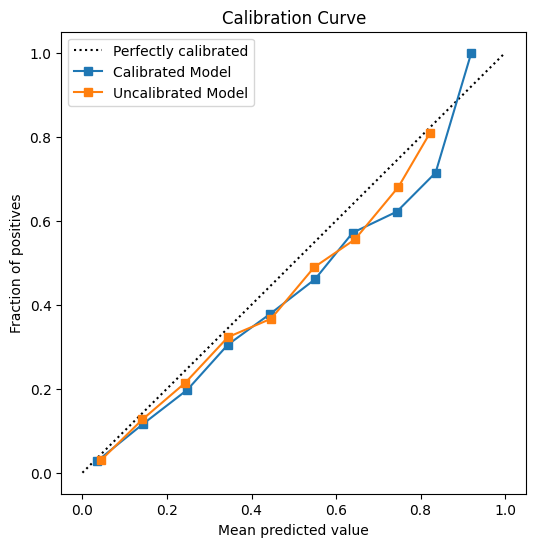

In [26]:
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives_wo_cal, mean_predicted_value_wo_cal = calibration_curve(test[target], preds_wo_cal, n_bins=10)
fraction_of_positives, mean_predicted_value = calibration_curve(test[target], preds, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrated Model")
plt.plot(mean_predicted_value_wo_cal, fraction_of_positives_wo_cal, "s-", label="Uncalibrated Model")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title('Calibration Curve')
plt.legend()
plt.show()

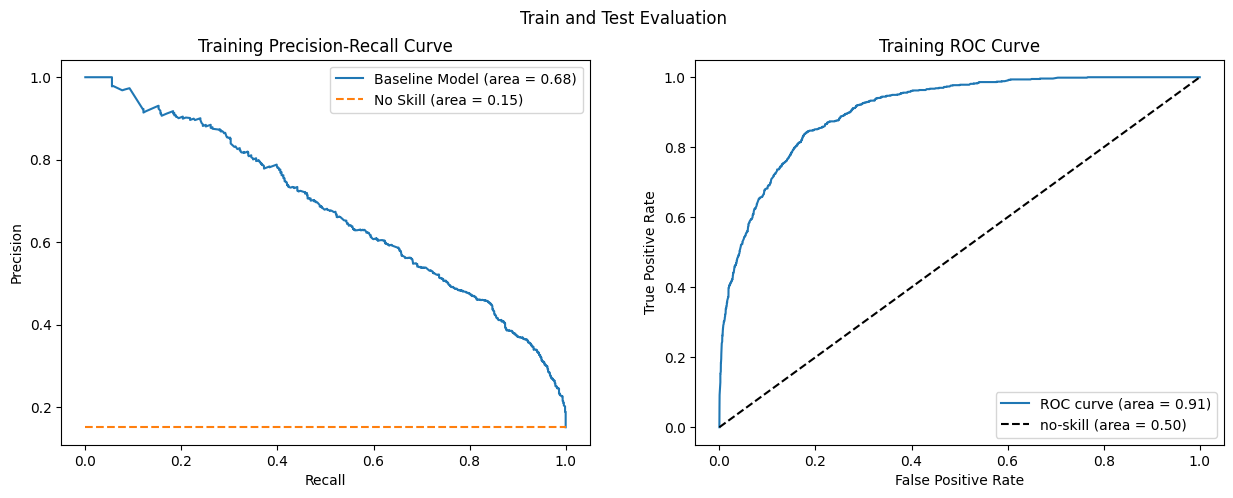

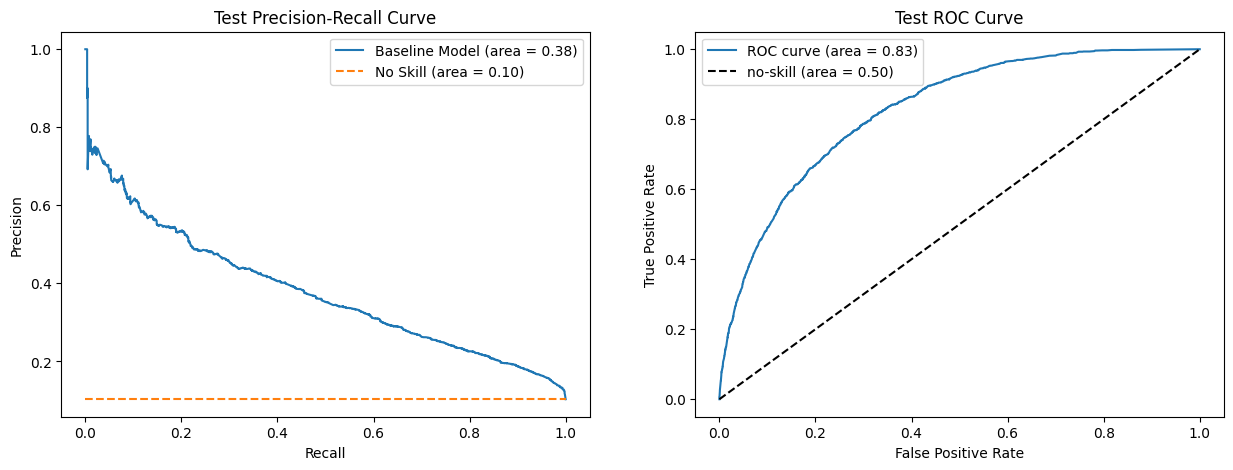

In [27]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

# SHAP Analysis

In [28]:
import shap
explainer = shap.TreeExplainer(uncalibrated_optimal_model[3])
shap_values = explainer.shap_values(test[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


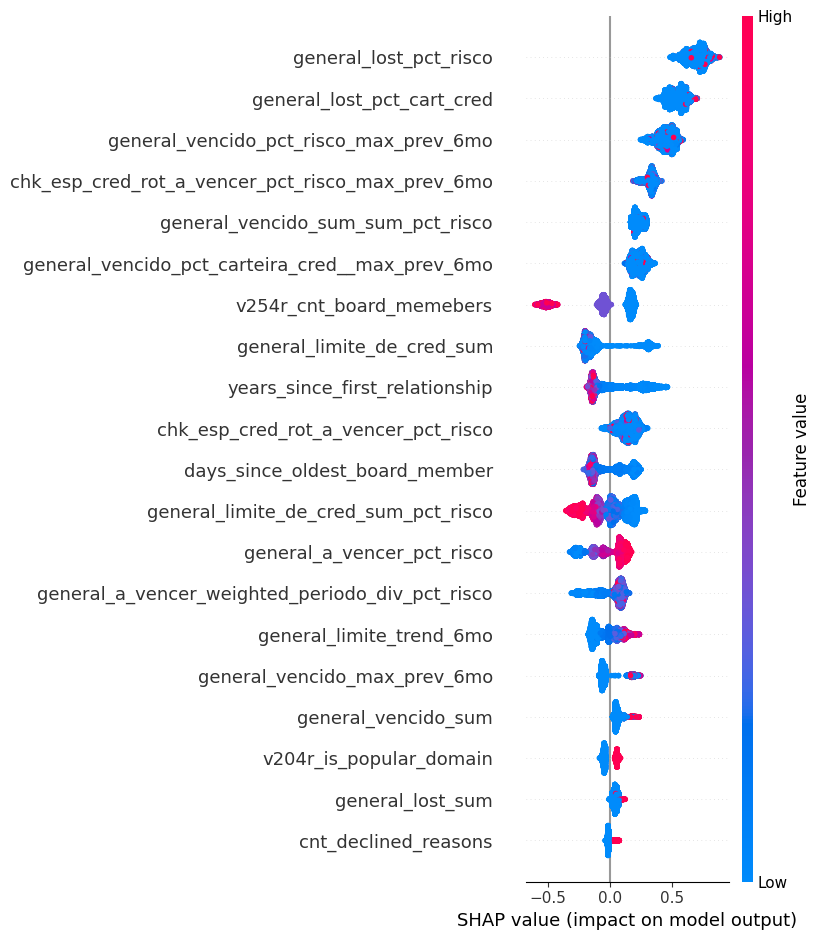

In [29]:
shap.summary_plot(shap_values[1], test[features])

In [30]:
# # Interaction between each feature pair
# for i in range(len(features)):
#     for j in range(len(features)):
#         if i != j:
#             print(f'Interaction between {features[i]} and {features[j]}')
#             shap.dependence_plot(ind=j, interaction_index=i, shap_values=shap_values[1], features=test[features], display_features=test[features], feature_names=features)


# Time-based Evaluation

divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


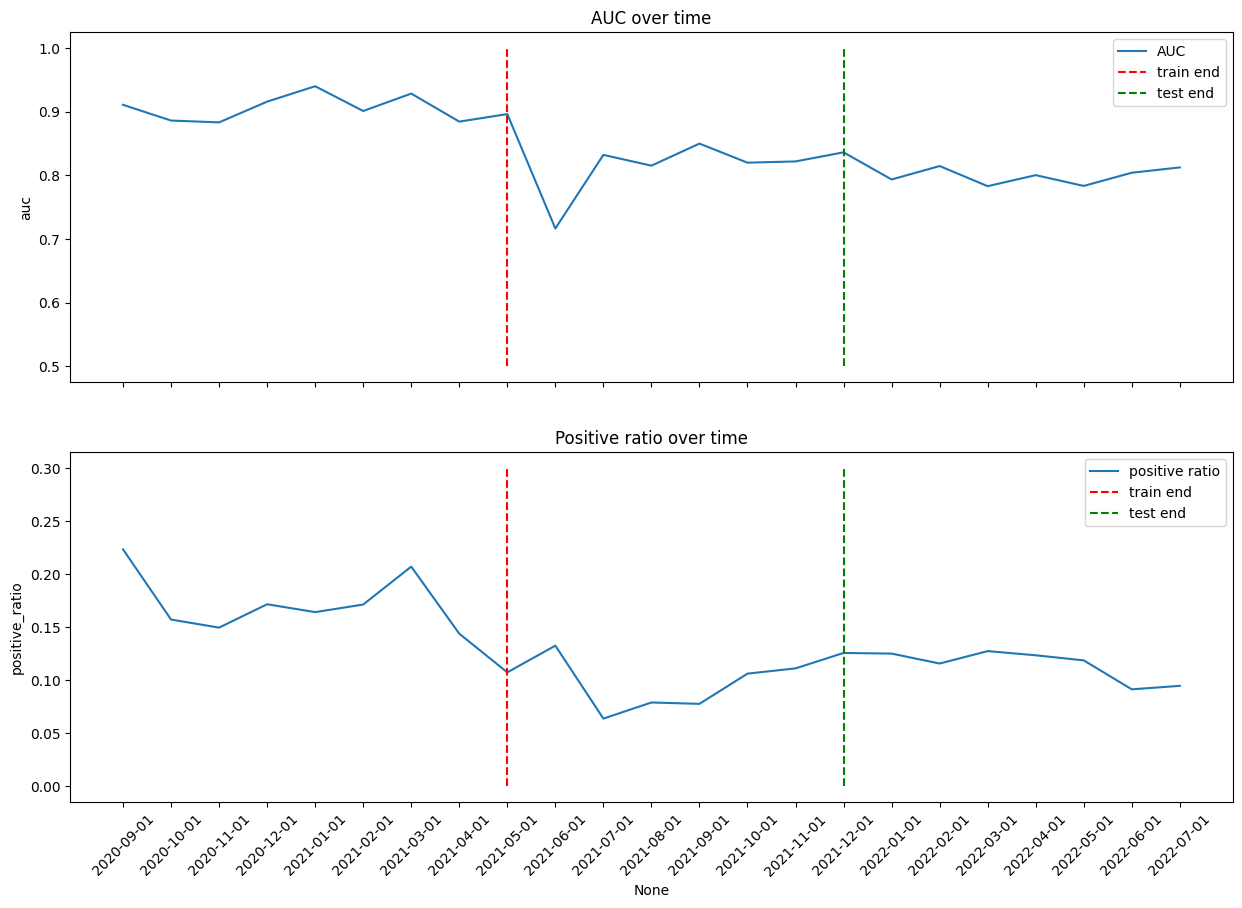

In [31]:
all_data['preds'] = optimal_model.predict_proba(all_data[features])[:, 1]
scored_df = time_based_evaluation(all_data, 'date_reference', target_col=target)

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

sns.lineplot(x=scored_df.index, y=scored_df['auc'], label='AUC', ax=ax[0])
ax[0].set_title('AUC over time')
ax[0].vlines(x=train['date_reference'].max(), ymin=0.5, ymax=1, color='r', linestyle='--', label='train end')
ax[0].vlines(x=test['date_reference'].max(), ymin=0.5, ymax=1, color='g', linestyle='--', label='test end')
ax[0].legend()

sns.lineplot(x=scored_df.index, y=scored_df['positive_ratio'], label='positive ratio', ax=ax[1])
ax[1].set_title('Positive ratio over time')
ax[1].vlines(x=train['date_reference'].max(), ymin=0, ymax=.3, color='r', linestyle='--', label='train end')
ax[1].vlines(x=test['date_reference'].max(), ymin=0, ymax=.3, color='g', linestyle='--', label='test end')
ax[1].legend()
ax[1].tick_params(axis='x', rotation=45)

plt.show()

# Saving the optimal model

In [32]:
# saving the model into a pickle file
import pickle
with open('artifacts/model.pkl', 'wb') as f:
    pickle.dump(fitted_model, f)